In [8]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

Question 5

In [21]:
for N in range(2, 41):
    is_prime = True
    for i in range(2, N):
        if N % i == 0:
            is_prime = False
            break
    if is_prime:
        print(N)

2
3
5
7
11
13
17
19
23
29
31
37


Question 6

In [23]:
primes = []
for N in range(2, 41):
    is_prime = True
    for i in range(2, N):
        if N % i == 0:
            is_prime = False
            break
    if is_prime:
        primes.append(N)

print(primes[::-1][:5])

[37, 31, 29, 23, 19]


Question 7

In [28]:
path = "data_etc/math.txt"

with open(path, 'r') as f:
    equations = f.readlines()

with open("solved_equations.txt", 'w') as f:
    for eq in equations:
        a, b = eq.split("=")[0].split('+')
        result = int(a) + int(b)

        # Husk at fjerne newline!
        f.write(f"{eq[:-1]} {result}\n")

Question 8 & 9: 

See respective files.

Question 10: 

In [29]:
valid = 0
with open("data_etc/names.txt", 'r') as f:
    for line in f:
        policy, password = line.split(': ')
        min_max, letter = policy.split()
        min_count, max_count = map(int, min_max.split('-'))
        count = password.count(letter)
        if min_count <= count <= max_count:
            valid += 1
print(f"Valid passwords: {valid}")

Valid passwords: 506


Question 11 

Text(0.5, 1.0, 'Spectrum from data_etc/sdssJ133702+305539_combined.dat')

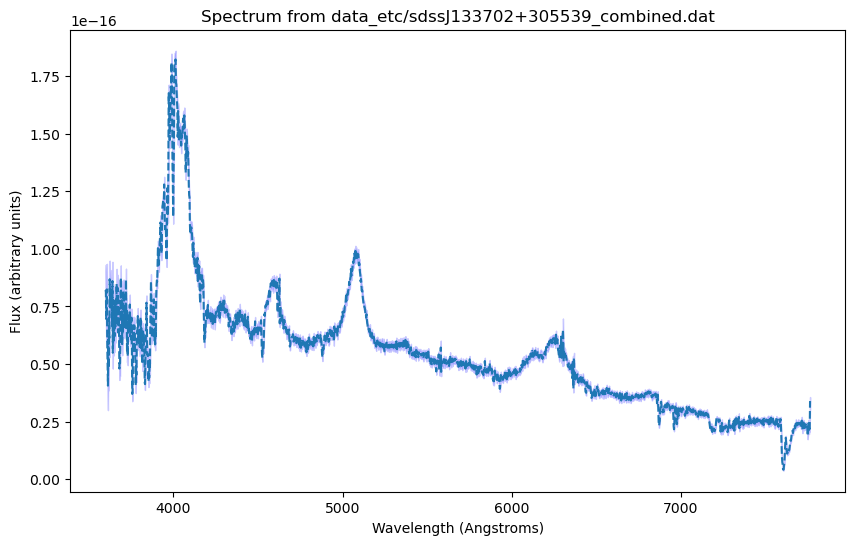

In [2]:
path = "data_etc/sdssJ133702+305539_combined.dat"

data = np.genfromtxt(path,  skip_header=1, delimiter=' ')

data[:,2] = np.sqrt(data[:,2])
plt.figure(figsize=(10,6))
plt.plot(data[:,0], data[:,1], '--')
plt.fill_between(data[:,0], data[:,1]-data[:,2], data[:,1]+data[:,2], color='blue', alpha=0.2)
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux (arbitrary units)")
plt.title("Spectrum from " + path)

Question 12:

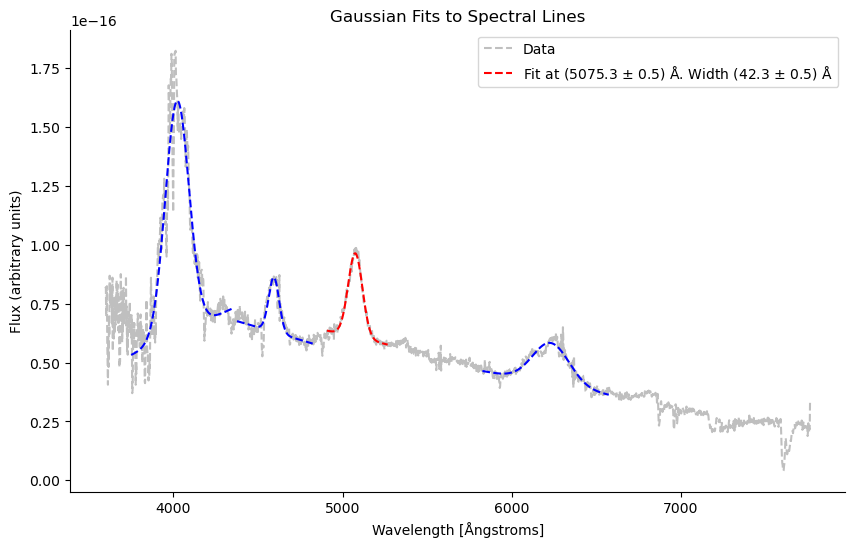

In [5]:
fitpeaks = [4050, 4600, 5087, 6200]
fit_widths = [200, 150, 120, 250]
fit_widths = np.array(fit_widths)*1.5


N = 2

def gaussian_on_linear_bg(x, amp, cen, wid, slope, intercept):
    return amp * np.exp(-(x-cen)**2 / (2*wid**2)) + slope*x + intercept

plt.figure(figsize=(10,6))
from scipy.optimize import curve_fit
plt.plot(data[:,0], data[:,1], '--', label='Data', alpha=0.5, c ='gray')
for peak, width in zip(fitpeaks, fit_widths):
    mask = (data[:,0] > peak - width) & (data[:,0] < peak + width)
    xdata = data[mask, 0]
    ydata = data[mask, 1]
    yerr = data[mask, 2]

    p0 = [np.max(ydata), peak, width/2, 0, np.median(ydata)]
    popt, pcov = curve_fit(gaussian_on_linear_bg, xdata, ydata, p0=p0, sigma=yerr)

    fitpeak = popt[1]
    fitwidth = popt[2]

    if N == 0:
        c = "r"
        label = f'Fit at ({fitpeak:.1f} $\\pm$ {np.sqrt(pcov[1,1]):.1f}) Å. Width ({np.abs(fitwidth):.3} $\\pm$ {np.sqrt(pcov[2,2]):.1}) Å'
    else:
        c = "b"
        label = None
        #add fit to legend

    plt.plot(xdata, gaussian_on_linear_bg(xdata, *popt), c+'--', label=label)
    N -= 1
plt.xlabel("Wavelength [Ångstroms]")
plt.ylabel("Flux (arbitrary units)")
plt.title("Gaussian Fits to Spectral Lines")
plt.legend()
sns.despine()
plt.show()

Question 13:

C:\Users\jakob\AppData\Local\Temp\ipykernel_13708\3173611692.py:7: RuntimeWarning: invalid value encountered in sqrt
  return mean, np.sqrt(variance)


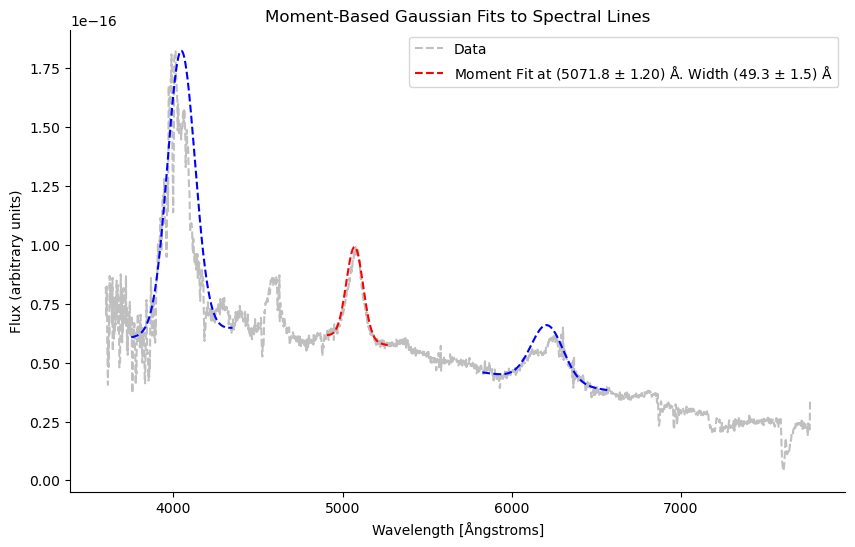

In [6]:
# usign moments
def moment_based_gaussian(x, y):
    """Estimate Gaussian parameters using moments."""
    total = np.sum(y)
    mean = np.sum(x * y) / total
    variance = np.sum(y * (x - mean)**2) / total
    return mean, np.sqrt(variance)
plt.figure(figsize=(10,6))

plt.plot(data[:,0], data[:,1], '--', label='Data', alpha=0.5, c ='gray')

N  = 2

for peak, width in zip(fitpeaks, fit_widths):
    mask = (data[:,0] > peak - width) & (data[:,0] < peak + width)
    xdata = data[mask, 0]
    ydata = data[mask, 1]

    # FFind linear background from edges of the window
    left_edge = ydata[0]
    right_edge = ydata[-1]
    slope = (right_edge - left_edge) / (xdata[-1] - xdata[0])
    intercept = left_edge - slope * xdata[0]
    
    ydata_bgsub = ydata - (slope * xdata + intercept)



    # stimate uncertainties via bootstrap: add random noise drawn from a normal distribu-
    # tion with standard deviations given by flux var, and repeat the moment calculation
    # many times (e.g. 300–1000 times). Use the mean and standard deviation of the resulting
    # distributions of μ and FWHM as the estimates and their uncertainties.



    n_bootstrap = 500
    means = []
    stddevs = []
    for _ in range(n_bootstrap):
        ydata_noisy = ydata_bgsub + np.random.normal(0, data[mask, 2])
        mean_bs, stddev_bs = moment_based_gaussian(xdata, ydata_noisy)
        means.append(mean_bs)
        stddevs.append(stddev_bs)

    mean_mean = np.mean(means)
    mean_uncertainty = np.std(means)

    mean_stddev = np.mean(stddevs)
    stddev_uncertainty = np.std(stddevs)


    gaussian_fit = np.max(ydata_bgsub) * np.exp(-(xdata - mean_mean)**2 / (2*mean_stddev**2)) + slope * xdata + intercept
    
    if N == 0:
        c = "r"
        label = f'Moment Fit at ({(mean_mean):.1f} $\\pm$ {mean_uncertainty:.2f}) Å. Width ({np.abs(mean_stddev):.1f} $\\pm$ {stddev_uncertainty:.1f}) Å'
    else:
        c = "b"
        label = None
        #add fit to legen
    N -= 1

    plt.plot(xdata, gaussian_fit, c+'--', label  = label)

plt.xlabel("Wavelength [Ångstroms]")
plt.ylabel("Flux (arbitrary units)")
plt.title("Moment-Based Gaussian Fits to Spectral Lines")
plt.legend()
sns.despine()
plt.show()

    
